# Monty Hall problem

## Classical Monty Hall
Imagine a game show with 3 doors. Behind two of them are goats, and behind the third is a luxury car. You initially choose one of the doors. Then, the host, who knows what is behind each door, opens one of the remaining doors to reveal a goat. At this point, you're given the option to either stick with your original choice or switch to the other unopened door. The question is: Is it better to switch, or is it just as good to stay with your original choice?

In [4]:
import random

def MontyHall():
    doors = [0, 0, 0]
    car_pos = random.randint(0, 2)
    doors[car_pos] = 1

    first_choice = random.randint(0, 2)
    win = -1
    if doors[first_choice] == 1:
        win = 1

    change_idea = random.randint(0, 1)
    if change_idea: 
        win *= -1 
    
    return win, change_idea


## General Monty Hall
The problem is the same but now the doors are $N$ and the possible choices are $p$.

In [5]:
import numpy as np

def general_MontyHall(n_doors=3, n_open_doors=1):
    result = {
        "initial_choice": None,
        "steps": [],
        "final_choice": None
    }
    
    doors = np.zeros(n_doors)
    car_pos = random.randint(0, n_doors - 1)
    doors[car_pos] = 1
    changes = [random.randint(0, 1) for _ in range(n_open_doors)]
    n_changes = np.sum(changes)

    choice_pos = random.randint(0, n_doors - 1)
    choice = doors[choice_pos]

    result["initial_choice"] = {"position": choice_pos, "value": choice}

    for change in changes: 
        open_door = 1
        while open_door:
            open_door_pos = random.randint(0, len(doors) - 1)
            if open_door_pos != choice_pos:
                open_door = doors[open_door_pos]

        doors = np.delete(doors, open_door_pos)
        
        # Update choice_pos if needed
        if open_door_pos < choice_pos:
            choice_pos -= 1

        if change:
            c = random.randint(0, len(doors) - 1)
            while c == choice_pos:
                c = random.randint(0, len(doors) - 1)            
            choice_pos = c

        choice = doors[choice_pos]

        result["steps"].append({
            "position": choice_pos,
            "value": choice,
            "change_made": bool(change)
        })
    
    result["final_choice"] = {"position": choice_pos, "value": choice, "n_changes": n_changes}
    
    return result


## Plot the results

In [ ]:
file_path = "/mnt/c/Users/User/Desktop/info/ES_AstroStatistic/Andrea_Morandi/Ex.1/plots/"

### Classical Monty Hall
We want to study the classical Monty Hall problem and at the same time verify that the two algorithm showed before converge to the same result in this limit. 

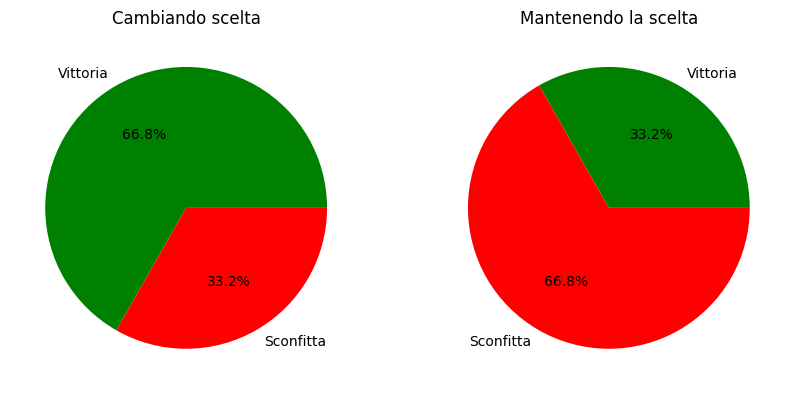

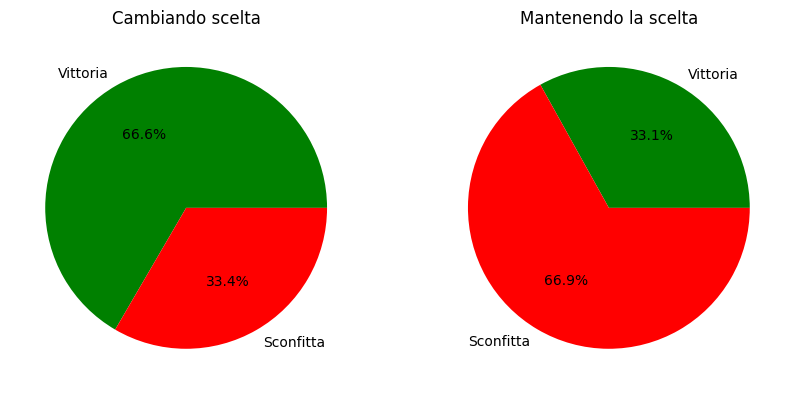

In [7]:
import matplotlib.pyplot as plt

def plot_classicalMontyHall(n_trials, generator, fileNamePNG="MontyHall.png"):
    results_change = []
    results_no_change = []

    for _ in range(n_trials):
        win = None
        change_idea = None
        result = generator()  

        if generator == general_MontyHall:
            win = 1 if result["final_choice"]["value"] == 1 else -1
            change_idea = 0 if result["final_choice"]["n_changes"] == 0 else 1
        
        elif generator == MontyHall:
            win, change_idea = result  

        
        if change_idea:
            results_change.append(win)
        else:
            results_no_change.append(win)

    # Contiamo le vittorie e sconfitte
    win_count_change = results_change.count(1)
    lose_count_change = results_change.count(-1)

    win_count_no_change = results_no_change.count(1)
    lose_count_no_change = results_no_change.count(-1)

    # Creazione dei grafici a torta
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    axs[0].pie([win_count_change, lose_count_change], labels=["Vittoria", "Sconfitta"], autopct='%1.1f%%', colors=["green", "red"])
    axs[0].set_title("Cambiando scelta")

    axs[1].pie([win_count_no_change, lose_count_no_change], labels=["Vittoria", "Sconfitta"], autopct='%1.1f%%', colors=["green", "red"])
    axs[1].set_title("Mantenendo la scelta")

    plt.savefig(file_path + fileNamePNG)
    plt.show()


plot_classicalMontyHall(10000, MontyHall)
plot_classicalMontyHall(10000, general_MontyHall, "general_MontyHall.png")



### General Monty Hall

We know that the general Monty hall problem have to follow the following equation: 
$$
f(N, p) = \frac{1}{N}\frac{N-1}{N-p-1}
$$
We can plot the results changing $N$ and $p$ to verify this rule.

In [ ]:
N_extreme = 25
p_extreme = 20
n_trials = 10000

N_values = np.arange(3, N_extreme)
P_values = np.arange(1, p_extreme)
results = np.zeros((len(N_values), len(P_values)))

for i, N in enumerate(N_values):
    for j, p in enumerate(P_values):
        results[i, j] = np.sum([general_MontyHall(N, p)["final_choice"]["value"] for _ in range(n_trials)]) / n_trials

X, Y = np.meshgrid(N_values, P_values)
F = (1 / X) * ((X - 1) / (X - Y - 1))

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, F, alpha=0.5, cmap='viridis', label='f(N, p)')

hist, xedges, yedges = np.histogram2d(X.ravel(), Y.ravel(), bins=[len(N_values), len(P_values)], weights=results.T.ravel())
xpos, ypos = np.meshgrid(xedges[:-1] + 0.5, yedges[:-1] + 0.5)
xpos = xpos.ravel()
ypos = ypos.ravel()
dz = hist.ravel()

ax.bar3d(xpos, ypos, np.zeros_like(dz), 1, 1, dz, shade=True, cmap='coolwarm', label="data")
plt.legend()
ax.set_title("Monty Hall Simulation vs Analytical Function")
ax.set_xlabel("N (Number of Doors)")
ax.set_ylabel("p (Number of Opened Doors)")
ax.set_zlabel("Winning Probability")
plt.savefig(file_path + "3D_plot.png")
plt.show()